# LDA Topic Modeling


In [221]:
import nltk
import json
import string
import gensim
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd
import re

from unidecode import unidecode
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from wordcloud import WordCloud
from sklearn import cluster

# Charger les données

In [105]:
def getId(liste, page, header):
    """
    les id des decisions en rapport avec les universités
    """
    param = "query=universite%20&jurisdiction=cc&jurisdiction=ca&jurisdiction=tj&date_start=2021-01-01&date_end=2024-01-01&page_size=50&page="+str(page)

    response = requests.get("https://sandbox-api.piste.gouv.fr/cassation/judilibre/v1.0/search?"+param,
                            headers=header)

    if response.status_code == 200:
        data = response.json()
        for decision in data["results"]:
            liste.append(decision["id"])

header = {"accept": "application/json",
          "KeyId": "80f0270f-5e79-4685-abfb-cb2b92e0c24e"}
list_id = list()
page = 0
while page < 13:
    getId(list_id, page, header)
    page = page + 1
print("Nombre de id récupéré: ",len(list_id))

Nombre de id récupéré:  635


In [106]:
data = list()

def get_text(id):
    """
    Extraire le texte intégrale des décisions 
    """
    response = requests.get("https://sandbox-api.piste.gouv.fr/cassation/judilibre/v1.0/decision?id="+id, headers=header)

    if response.status_code == 200:
        d = response.json()
        data.append([d["text"]])

for id in list_id:
    get_text(id)


# Pré-traitement

In [109]:
# Miniscule
data = [[mot.lower() for mot in t] for t in data]

# Suppression des ponctuation 
data = ["".join([c for c in list(t) if not (c in list(string.punctuation))]) for t in data]

# Tokenisation
data_quote = [word_tokenize(text) for text in data]

# Stemmatisation
ps = PorterStemmer()
data_st = [[ps.stem(word) for word in t] for t in data_quote]

# Lemmatisation
lem = WordNetLemmatizer()
data_lm = [[lem.lemmatize(word) for word in t] for t in data_st]

In [110]:
# Stopwords
stop_words = stopwords.words("french")
stop_words.extend(["cassat", "audienc", "publiqu", "peupl", "chambr", "civil", "domicilié", "cour", "larrêt", "arrêt",
                   "présidentiel", "juin", "pourvoi", "rejet", "société", "salarié", "ainsi", "juin", "juillet", "lemployeur",
                   "madam", "monsieur", "jugement", "droit", "localité", "larticl", "procédur", "décision", "quell", "janvier",
                   "février", "avoir, d'appel", "contrat", "aucun", "demand", "disposit", "avoir", "septembr",
                   "décembr","conclus", "novembr", "avocat", "dappel", "conseil", "adress", "salair","condamn", "notam", "avant", 
                   "premier", "octobr", "avril", "préjudic", "qualite", "procureur", "rapport", "parti", "judiciair", "professionnel",
                   "dernier", "qualite", "appel", "payer", "consequenc", "qualité", "articl", "élément", "selon", "suivant", "conséquenc",
                   "tribun", "motif", "condamné", "montant", "condit", "interêt", "applic", "rendu", "paiement", "intérêt", "produit",
                   "franc","personn","represente","format", "présent", "emploi", "laquel", "barreau", "greffier", "juger", "public",
                   "servic", "claus", "rappel", "compt", "charg", "dépen", "compter", "périod", "prudhomm", "conclus", "personnel",
                   "devant", "travail", "greff", "lanne", "débouté", "statuant", "raison", "représent", "premier", "résult", "prévu",
                   "pendant", "alinéa", "également", "moyen", "débouter", "litig", "établi", "président", "fonction", "tableau",
                   "grief", "débat", "françai", "délai", "déclare", "déclarat", "premièr"])
data_sw = [[word for word in text if word not in stop_words] for text in data_lm]
print(data_sw[0])

['civ', '1', 'cf', '3', 'mar', '2021', 'mme', 'batut', 'n°', '183', 'fsp', 'n°', 'k', '1922855', 'r', 'é', 'p', 'u', 'b', 'i', 'q', 'u', 'e', 'f', 'r', 'a', 'ç', 'a', 'i', 'e', 'nom', '3', 'mar', '2021', 'h', 'dit', 'a', 'formé', 'n°', 'k', '1922855', 'contr', '28', 'mai', '2019', 'pari', 'pôle', '1chambr', '1', 'dan', 'loppos', '1°', 'luniversité', 'dont', 'sièg', '2°', 'abou', 'dhabi', 'educ', 'council', 'adec', 'dont', 'sièg', '3°', 'ministèr', 'affair', 'emirat', 'arab', 'uni', 'pri', 'ministr', 'affair', 'ambassad', 'emirat', 'arab', 'uni', 'dont', 'sièg', '4°', 'f', 'b', 'u', 'défendeur', 'demandeur', 'invoqu', 'lappui', 'deux', 'annexé', 'dossier', 'a', 'communiqué', 'général', 'fulchiron', 'observ', 'scp', 'baraduc', 'duhamel', 'rameix', 'dit', 'scp', 'piwnica', 'molinié', 'ministèr', 'affair', 'émirat', 'arab', 'uni', 'lavi', 'mme', 'carondéglis', 'général', 'aprè', 'laudienc', '12', '2021', 'où', 'mme', 'batut', 'fulchiron', 'rapporteur', 'mme', 'auroy', 'doyen', 'mme', 'anto

In [111]:

# On remarque beaucoup de lettre à 1 caractère, des suites d'underscores et de chiffres, on les enlève 

data_sw = [[word for word in text if not word.isdigit()] for text in data_sw]
data_sw = [[word for word in text if len(word) >= 5] for text in data_sw]
data_sw = [[unidecode(word) for word in text] for text in data_sw]
data_sw = [[word for word in text if word[-1] in "s" or "e"] for text in data_sw]

print(data_sw[0])

['batut', 'forme', 'contr', '1chambr', 'loppos', 'luniversite', 'dhabi', 'council', 'minister', 'affair', 'emirat', 'ministr', 'affair', 'ambassad', 'emirat', 'defendeur', 'demandeur', 'invoqu', 'lappui', 'annexe', 'dossier', 'communique', 'general', 'fulchiron', 'observ', 'baraduc', 'duhamel', 'rameix', 'piwnica', 'molinie', 'minister', 'affair', 'emirat', 'carondeglis', 'general', 'laudienc', 'batut', 'fulchiron', 'rapporteur', 'auroy', 'doyen', 'antoin', 'vigneau', 'bozzi', 'poinseaux', 'moutytardieu', 'gargoullaud', 'buatmenard', 'feydeauthieffri', 'referendair', 'carondeglis', 'general', 'berthomi', 'compose', 'lorganis', 'precite', 'delibere', 'conforme', 'desistement', 'partiel', 'donne', 'desistement', 'dirige', 'contr', 'dhabi', 'council', 'upsad', 'attaque', 'renvoi', 'assigne', 'minister', 'affair', 'emirat', 'minister', 'remunerat', 'accompli', 'limplant', 'emirat', 'etabliss', 'denseign', 'superieur', 'partenariat', 'luniversite', 'parissorbonn', 'minister', 'oppose', 'dem

# Utilisation de Gensim 

In [112]:
dic = Dictionary(data_sw)
print(dic)
# Bag of word 
data_bow = [dic.doc2bow(text) for text in data_sw]


Dictionary<27352 unique tokens: ['1chambr', 'absolu', 'accompli', 'accord', 'accueilli']...>


In [131]:
# Technique LDA
lda = LdaModel(corpus=data_bow, id2word=dic,num_topics=15)
topic = lda.print_topics(num_words=50)
print(topic)


[(0, '0.007*"licenci" + 0.003*"conge" + 0.003*"dommag" + 0.003*"instanc" + 0.003*"social" + 0.003*"lentrepris" + 0.003*"effet" + 0.003*"convent" + 0.002*"direct" + 0.002*"securite" + 0.002*"justifi" + 0.002*"fonde" + 0.002*"concern" + 0.002*"reell" + 0.002*"prononce" + 0.002*"sante" + 0.002*"serum" + 0.002*"dernier" + 0.002*"mesur" + 0.002*"ruptur" + 0.002*"nouveau" + 0.002*"serieus" + 0.002*"moral" + 0.002*"confirm" + 0.002*"indemnite" + 0.002*"fondement" + 0.002*"activite" + 0.002*"dindemnite" + 0.002*"francais" + 0.002*"prise" + 0.002*"lassoci" + 0.002*"ordonn" + 0.002*"caracter" + 0.002*"supplementair" + 0.002*"oblig" + 0.002*"valmet" + 0.002*"natur" + 0.002*"signe" + 0.002*"verse" + 0.002*"luniversite" + 0.002*"collect" + 0.002*"prevue" + 0.002*"lexecut" + 0.002*"valoir" + 0.002*"verser" + 0.002*"defaut" + 0.002*"precise" + 0.002*"depui" + 0.002*"prealabl" + 0.002*"courrier"'), (1, '0.006*"licenci" + 0.003*"serum" + 0.003*"securite" + 0.003*"prise" + 0.003*"represente" + 0.002*"si

In [135]:
print(lda.get_term_topics("licenci", minimum_probability=0))


[(0, 0.0068785483), (1, 0.0063211494), (2, 0.0069099395), (3, 0.0070841843), (4, 0.0074078734), (5, 0.0046778587), (6, 0.0043554287), (7, 0.007959692), (8, 0.0046664784), (9, 0.0047776466), (10, 0.0031743385), (11, 0.004731704), (12, 0.004535013), (13, 0.0037321858), (14, 0.004914004)]


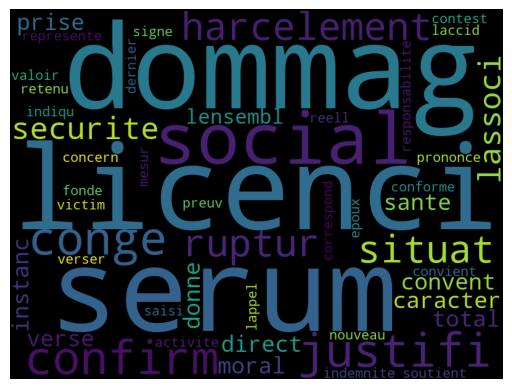

In [133]:
nl = []
for element in topic:
  texte_modifie = re.sub(r"\d+\.\d+|\*|\"", "", element[1])
  vir = re.sub(r"\+", ",", texte_modifie)
  nl.append((element[0], vir))

l = []
for i in nl[5]:
    if i != 5:
      l.append(i)
chaine = ", ".join(l)

wc = WordCloud(width=800, height=600)
wc.generate(chaine)

plt.imshow(wc)
plt.axis("off")
plt.show()

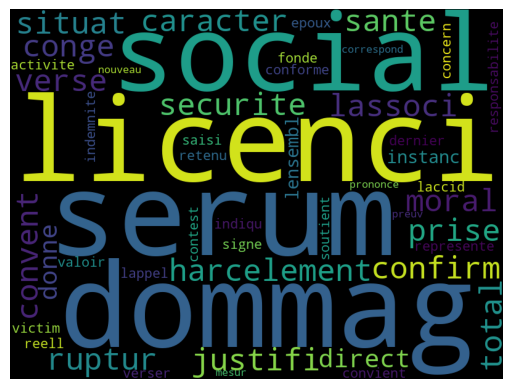

In [138]:
h = []
for i in nl[7]:
    if i != 7:
      h.append(i)
chaineh = ", ".join(h)

wc = WordCloud(width=800, height=600)
wc.generate(chaine)

plt.imshow(wc)
plt.axis("off")
plt.show()

In [141]:
doc_topic = lda.get_document_topics(data_bow)
matrice = corpus2csc(doc_topic).T.toarray()
print(matrice)

[[0.16651511 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.99902511 0.        ]
 [0.50947404 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.069111   0.         0.0416104  ... 0.         0.         0.        ]
 [0.         0.         0.14946337 ... 0.         0.         0.        ]
 [0.05291715 0.         0.         ... 0.         0.         0.        ]]


# Clustering

## TF-IDF

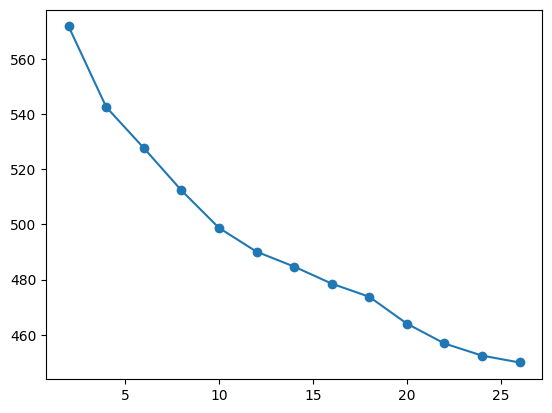

In [160]:
tfidf = TfidfVectorizer(
                        min_df = 5,
                        max_df = 0.95,
                       )

cleanData = [" ".join(t) for t in data_sw]

text = tfidf.fit_transform(cleanData)

def find_optimal_clusters(d, max_k):
    iters = range(2, max_k+1, 2)
    
    inertia = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=20,).fit(d)
        inertia.append(kmeans.inertia_)      

    plt.plot(iters, inertia, marker='o')
    plt.show()

find_optimal_clusters(text, 26)


## Mots clés par cluster 

In [217]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
clusters = MiniBatchKMeans(n_clusters=20, random_state=20).fit_predict(text)

top = get_top_keywords(text, clusters, tfidf.get_feature_names_out(), 30)




Cluster 0
pathologiqu,reconnaiss,securite,collegu,poste,douleur,avantdir,surcharg,risqu,inoppos,petition,preexist,thoraciqu,pathologi,danger,medecin,caracter,victim,dexpertis,representant,infarctu,medical,conscienc,consort,covid,rythm,retour,cardiaqu,inexcus,laccid

Cluster 1
saisi,chacun,liberte,linstruct,selarl,penale,represente,daction,factuel,darbitrag,arbitral,fiscal,batonnier,success,lordonn,twitter,operat,propo,intern,propriete,dinstanc,recour,honorair,maitr,associe,sentenc,larbitr,desistement,arbitr,notair

Cluster 2
objectif,dommagesinteret,prise,directeur,entretien,requalif,reclass,convent,agiss,situat,indemnite,preavi,adresse,manag,afferent,sante,direct,courrier,medecin,dindemnite,courriel,dommag,serieus,ruptur,reell,conge,moral,licenci,harcelement,lassoci

Cluster 3
laposuniversite,quaposa,attaque,laposag,daposautr,epoux,conge,laposindemnite,naposetait,pilot,quaposun,naposavait,laposexist,supplementair,daposheur,licenci,laposespec,quaposau,viole,daposavoir,naposest,naposa,

# Comparaison

In [220]:

topic5 = [] # famille

for i, row in enumerate(matrice):
    if row[5] == max(row):  
        topic5.append(i)

clus_harce = list()
for i, clu in enumerate(clusters):
    if clu == 15:
        clus_harce.append(i)


print("Nombre de texte dans le clusturing : ", len(clus_harce))
print("Nombre de texte dans le topic : ", len(topic5))

print("Texte en commun : ", len(set(clus_harce) & set(topic5)))


Nombre de texte dans le clusturing :  24
Nombre de texte dans le topic :  37
Texte en commun :  12
